In [1]:
import os
import json
import pandas as pd
from tqdm import tqdm
from datetime import datetime

# 경로 설정
base_path = 'C:/analyst/StatsBomb Open Data/open-data-master/data'
events_path = os.path.join(base_path, 'events')
refined_path = os.path.join(base_path, 'refined_events')
os.makedirs(refined_path, exist_ok=True)

# JSON 평탄화 함수
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if isinstance(x, dict):
            for a in x:
                flatten(x[a], f'{name}{a}.')
        elif isinstance(x, list):
            out[name[:-1]] = x
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

# 한 경기 이벤트 데이터 전처리 함수 (최종 최적화 버전)
def refine_match_events(events_filepath, match_id):
    with open(events_filepath, 'r', encoding='utf-8') as f:
        events_json = json.load(f)

    events_list = []

    for event in events_json:
        timestamp_str = event.get('timestamp')
        try:
            dt = datetime.strptime(timestamp_str, "%H:%M:%S.%f")
        except ValueError:
            dt = datetime.strptime(timestamp_str, "%H:%M:%S")
        time_in_seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
        event_data = {
            'match_id': match_id,
            'event_id': str(event.get('id'))[:4],
            'event_id_full': event.get('id'),
            'period': event.get('period'),
            'time': time_in_seconds,
            'team_name': event.get('team', {}).get('name'),
            'player_name': event.get('player', {}).get('name'),
            'player_position': event.get('position', {}).get('name'),
            'play_pattern': event.get('play_pattern', {}).get('name'),
            'event_type': event.get('type', {}).get('name'),
            'location': event.get('location')
        }

        # 하위 구조 자동 추출 (flatten)
        flat_event = flatten_json(event)

        # 🔥 명시적으로 삭제할 키 정확히 정의
        drop_keys_range = ['id', 'index', 'minute', 'second', 'type.id', 'type.name',
                           'possession', 'possession_team.id', 'possession_team.name',
                           'play_pattern.id', 'play_pattern.name', 'team.id', 'team.name',
                           'duration', 'tactics.formation', 'tactics.lineup', 'related_events',
                           'player.id', 'position.id', 'position.name']

        fixed_columns = [
            'match_id', 'event_id', 'event_id_full', 'period', 'timestamp',
            'team_name', 'player_name', 'player_position', 'play_pattern',
            'event_type', 'location']
        drop_keys_id_suffix = [
            key for key in flat_event.keys()
            if key.endswith('.id') and key not in fixed_columns]

        # 실제로 명확히 키 제거
        for key in drop_keys_range + drop_keys_id_suffix:
            flat_event.pop(key, None)

        # tags 컬럼 생성 (리스트형 값 예외처리 포함)
        tags = {}
        for key, value in flat_event.items():
            if key not in event_data:
                if isinstance(value, list):
                    if len(value) > 0:
                        tags[key] = value
                elif pd.notna(value):
                    tags[key] = value

        event_data['tags'] = tags
        events_list.append(event_data)

    events_df = pd.DataFrame(events_list)

    # 좌표 변환 (120x80 → 104x68)
    def convert_coords(loc, old_x=120, old_y=80, new_x=104, new_y=68):
        if loc is None:
            return [None, None]
        x, y = loc
        return [(x / old_x) * new_x, (y / old_y) * new_y]

    events_df['location'] = events_df['location'].apply(convert_coords)

    # (추가) tags의 1-depth에서 'location'이 들어간 키의 값만 좌표 스케일링
    def _scale_tag_loc(d):
        if not isinstance(d, dict):
            return d
        out = {}
        for k, v in d.items():
            if isinstance(k, str) and 'location' in k.lower():
                # [x, y] 형태
                if isinstance(v, (list, tuple)) and len(v) == 2 and all(isinstance(n, (int, float)) for n in v):
                    v = convert_coords([v[0], v[1]])
                # {'x': x, 'y': y} 형태
                elif isinstance(v, dict) and isinstance(v.get('x'), (int, float)) and isinstance(v.get('y'), (int, float)):
                    sx, sy = convert_coords([v['x'], v['y']])
                    v = {**v, 'x': sx, 'y': sy}
            out[k] = v
        return out

    events_df['tags'] = events_df['tags'].apply(_scale_tag_loc)


    # 컬럼 순서 명확히 조정 (tags 컬럼을 event_type과 location 사이에 위치)
    desired_order = [
        'match_id', 'event_id', 'event_id_full', 'period', 'time',
        'team_name', 'player_name', 'player_position', 'play_pattern',
        'event_type', 'tags', 'location'
    ]
    events_df = events_df[desired_order]

    return events_df

# 전체 경기 자동 처리
def refine_all_events():
    event_files = os.listdir(events_path)
    match_ids = [file.replace('.json', '') for file in event_files]

    for match_id in tqdm(match_ids, desc="Refining StatsBomb events (final fixed version)"):
        events_filepath = os.path.join(events_path, f'{match_id}.json')

        if not os.path.exists(events_filepath):
            print(f"파일이 없습니다: {events_filepath}")
            continue

        events_df = refine_match_events(events_filepath, match_id)

        # 저장
        save_path = os.path.join(refined_path, f'{match_id}.pkl')
        events_df.to_pickle(save_path)

    print(f"✅ 모든 refined 이벤트 데이터 저장 완료! ({refined_path})")

# 실행
if __name__ == "__main__":
    refine_all_events()


Refining StatsBomb events (final fixed version): 100%|██████████| 3433/3433 [27:43<00:00,  2.06it/s]

✅ 모든 refined 이벤트 데이터 저장 완료! (C:/analyst/StatsBomb Open Data/open-data-master/data\refined_events)


In [2]:
import pandas as pd

# 모든 컬럼 보기 설정
pd.set_option('display.max_columns', None)        # 모든 열 표시
pd.set_option('display.max_rows', 20)             # 최대 20행까지 출력
pd.set_option('display.max_colwidth', None)       # 열 너비 제한 없음
pd.set_option('display.width', None)              # 자동 줄바꿈 해제

# 파일 경로 (match_id에 따라 바꾸세요)
match_id = '3857284'
filepath = f'C:/analyst/StatsBomb Open Data/open-data-master/data/refined_events/{match_id}.pkl'

# 데이터 불러오기
df = pd.read_pickle(filepath)

# 필요에 따라 샷 이벤트만 따로 볼 수 있도록 설정
shots_only = False  # ← 여기서 True/False를 바꿔주세요.

if shots_only:
    df_filtered = df[df['event_type'] == 'Shot']
else:
    df_filtered = df

# event_id_full 제외 후 상위 20행 출력
print(df_filtered.drop(columns=['event_id_full']).iloc[0:2000].to_string())



     match_id event_id  period      time team_name         player_name            player_position    play_pattern      event_type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       


✅ 1. 데이터 기본 구조 확인
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   match_id         3762 non-null   object 
 1   event_id         3762 non-null   object 
 2   event_id_full    3762 non-null   object 
 3   period           3762 non-null   int64  
 4   time             3762 non-null   float64
 5   team_name        3762 non-null   object 
 6   player_name      3748 non-null   object 
 7   player_position  3748 non-null   object 
 8   play_pattern     3762 non-null   object 
 9   event_type       3762 non-null   object 
 10  tags             3762 non-null   object 
 11  location         3762 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 352.8+ KB
None

✅ 2. 컬럼별 결측치 점검
match_id            0
event_id            0
event_id_full       0
period              0
time                0
team_name           0
player_name

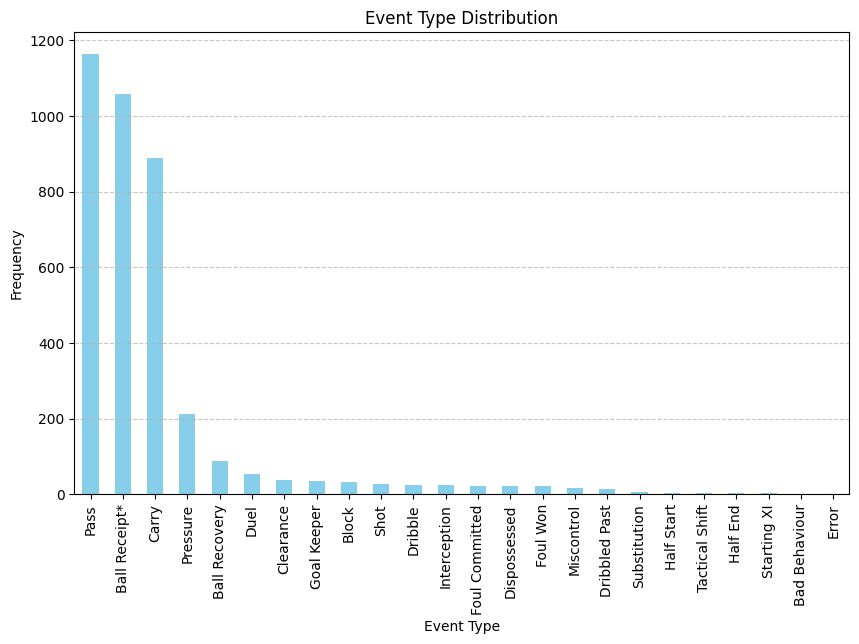


✅ 4. 좌표 데이터(location) 기본 점검


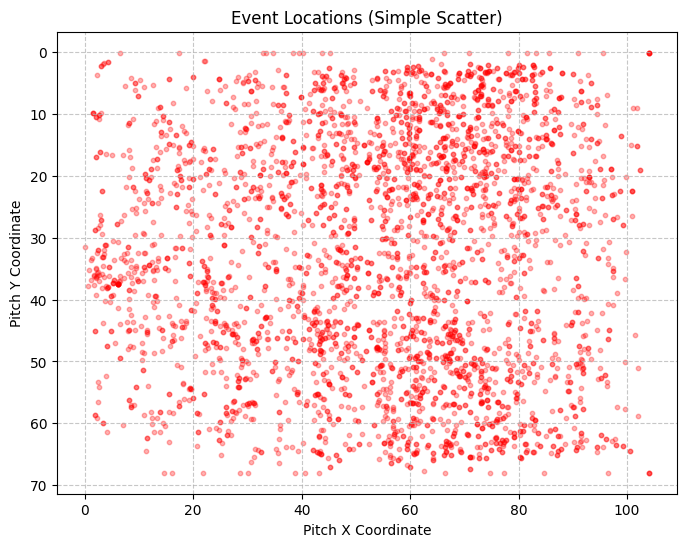

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 경로 (반드시 본인의 경로 확인!)
refined_path = 'C:/analyst/StatsBomb Open Data/open-data-master/data/refined_events'

# 임의로 한 개의 전처리 완료된 파일 로딩
sample_file = next((f for f in os.listdir(refined_path) if f.endswith('.pkl')), None)
if sample_file is None:
    raise FileNotFoundError("데이터가 없습니다.")

df = pd.read_pickle(os.path.join(refined_path, sample_file))

# 1. 데이터 기본 구조 확인
print("\n✅ 1. 데이터 기본 구조 확인")
print(df.info())

# 2. 컬럼별 결측치 점검
print("\n✅ 2. 컬럼별 결측치 점검")
print(df.isna().sum())

# 3. 이벤트 타입 빈도 점검
print("\n✅ 3. 이벤트 타입 빈도 점검")
event_counts = df['event_type'].value_counts()
print(event_counts.head(10))

# 이벤트 타입 분포 시각화
event_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. 좌표 데이터(location) 기본 점검 (scatter plot)
print("\n✅ 4. 좌표 데이터(location) 기본 점검")

locations = df['location'].dropna().tolist()
x, y = zip(*locations)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, color='red', s=10)
plt.title('Event Locations (Simple Scatter)')
plt.xlabel('Pitch X Coordinate')
plt.ylabel('Pitch Y Coordinate')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
